# Medical Image Classification

In [310]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [195]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [196]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [197]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [184]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Visualization

In [92]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([525, 133, 242,  28, 292, 157, 902, 431, 282, 295])

In [93]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

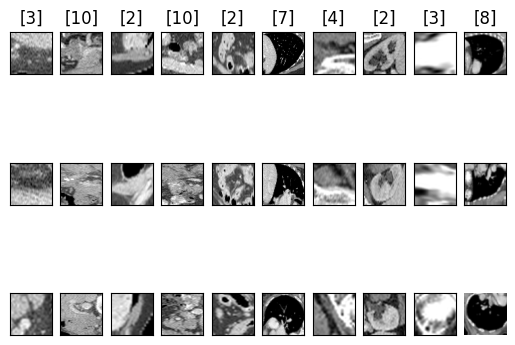

<Figure size 700x1500 with 0 Axes>

In [94]:
show_slice(train_dataset_, idx)

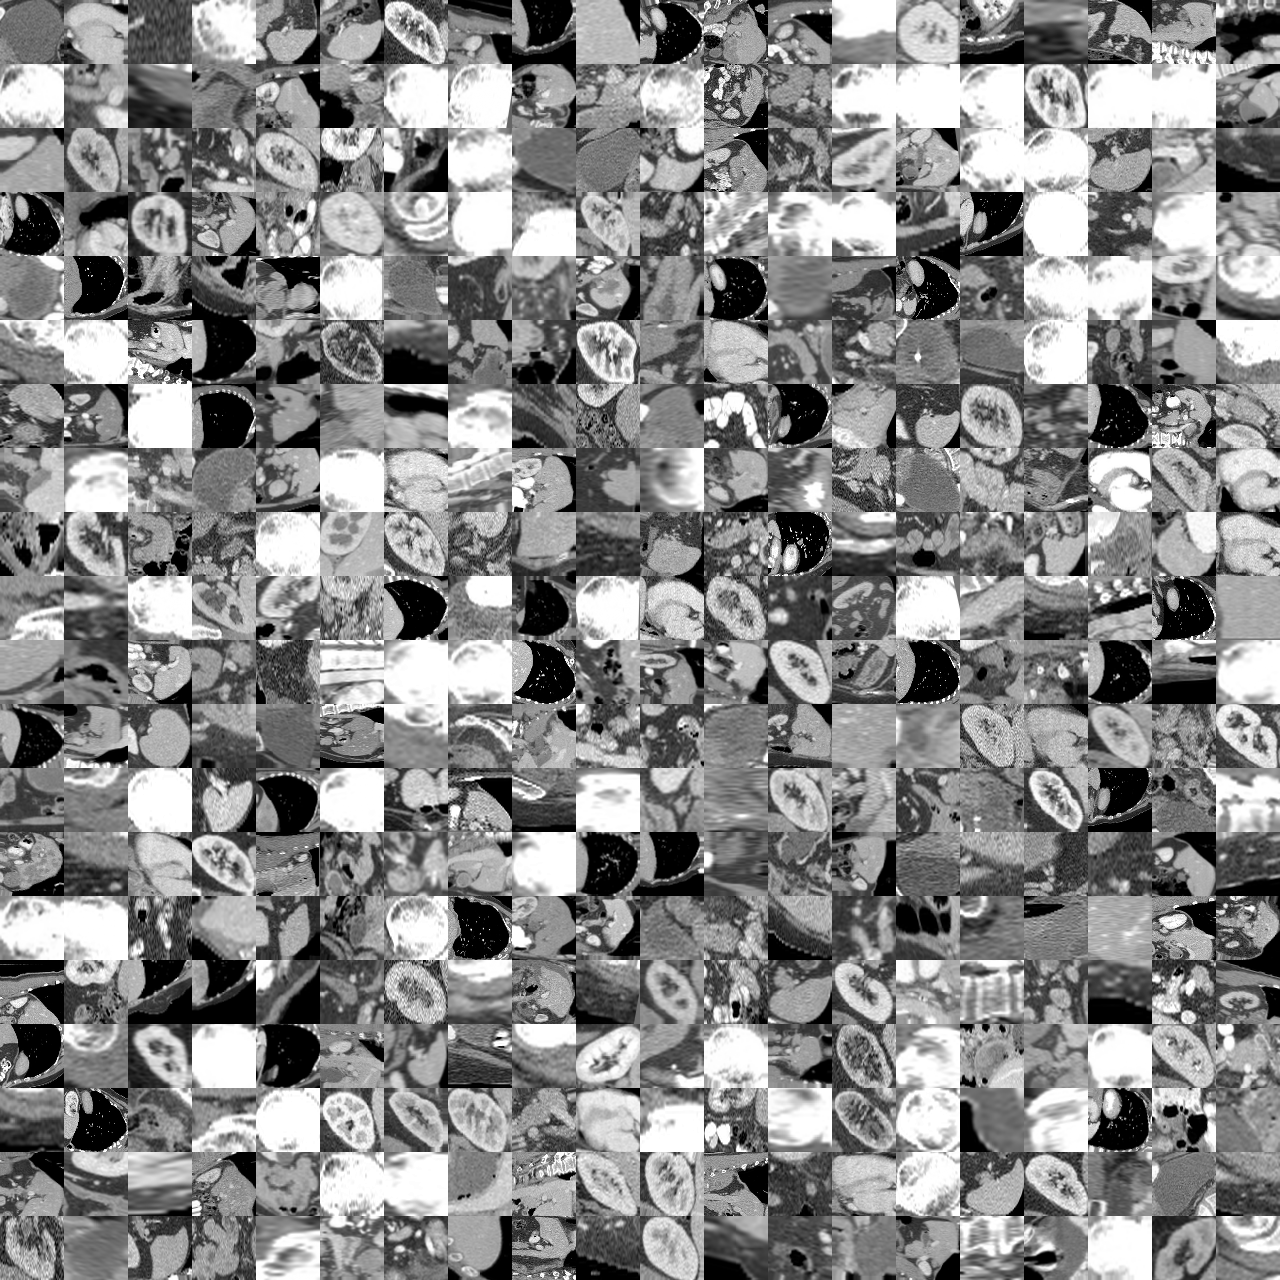

In [12]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

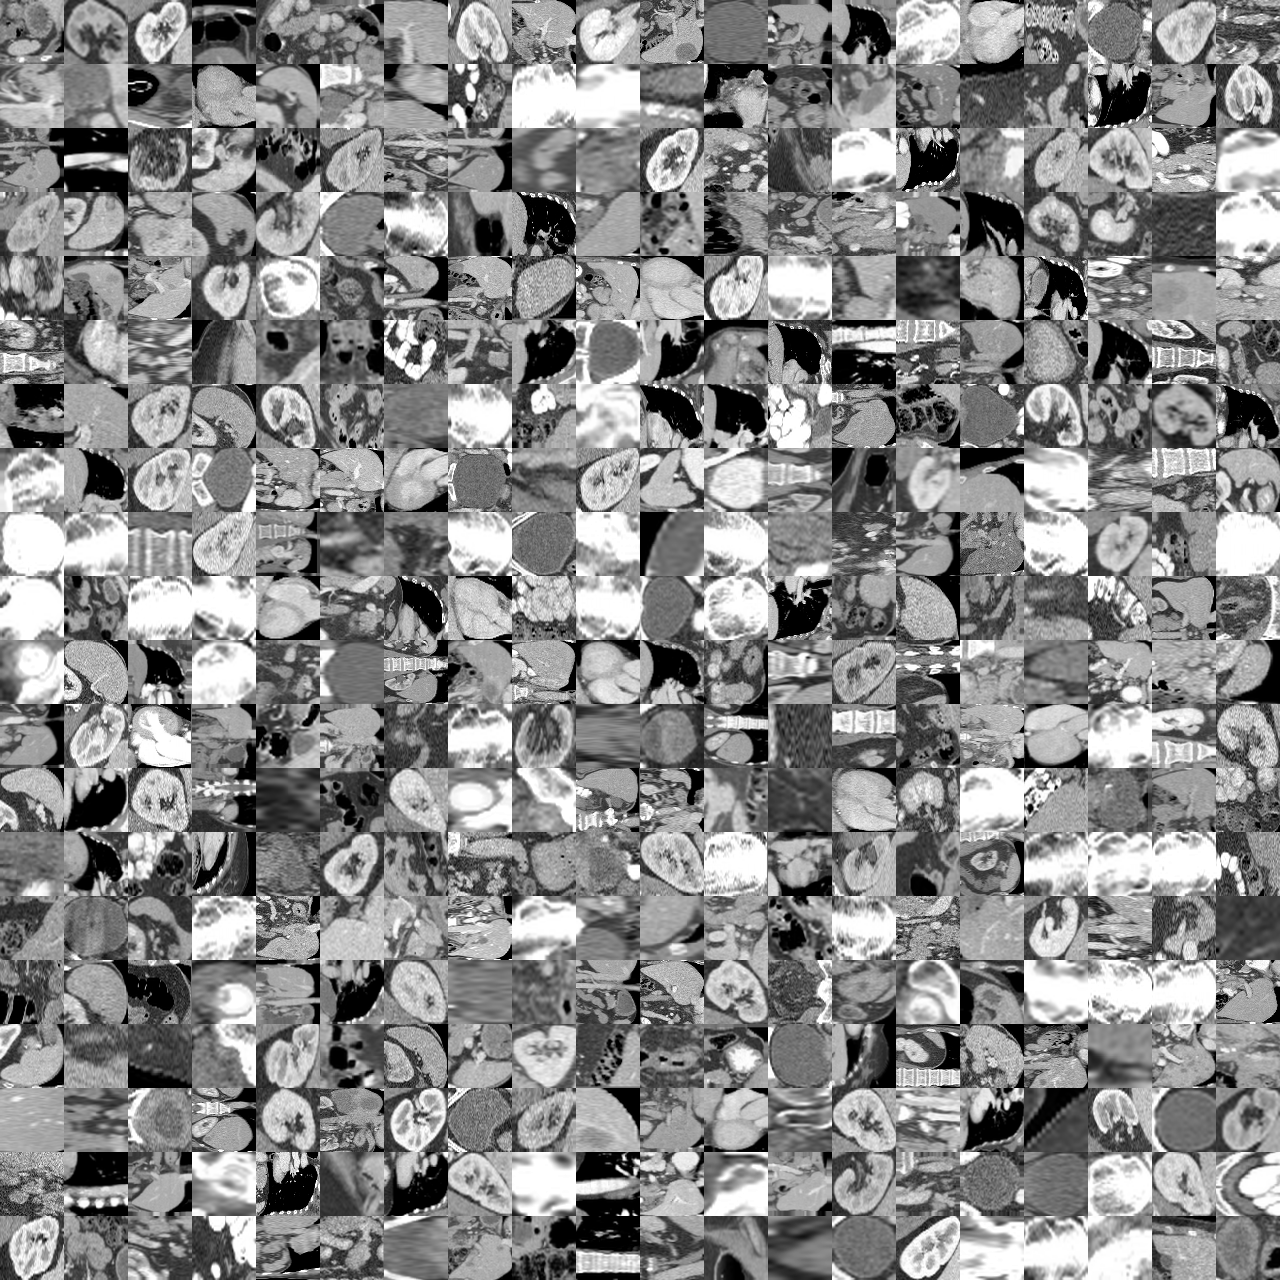

In [13]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

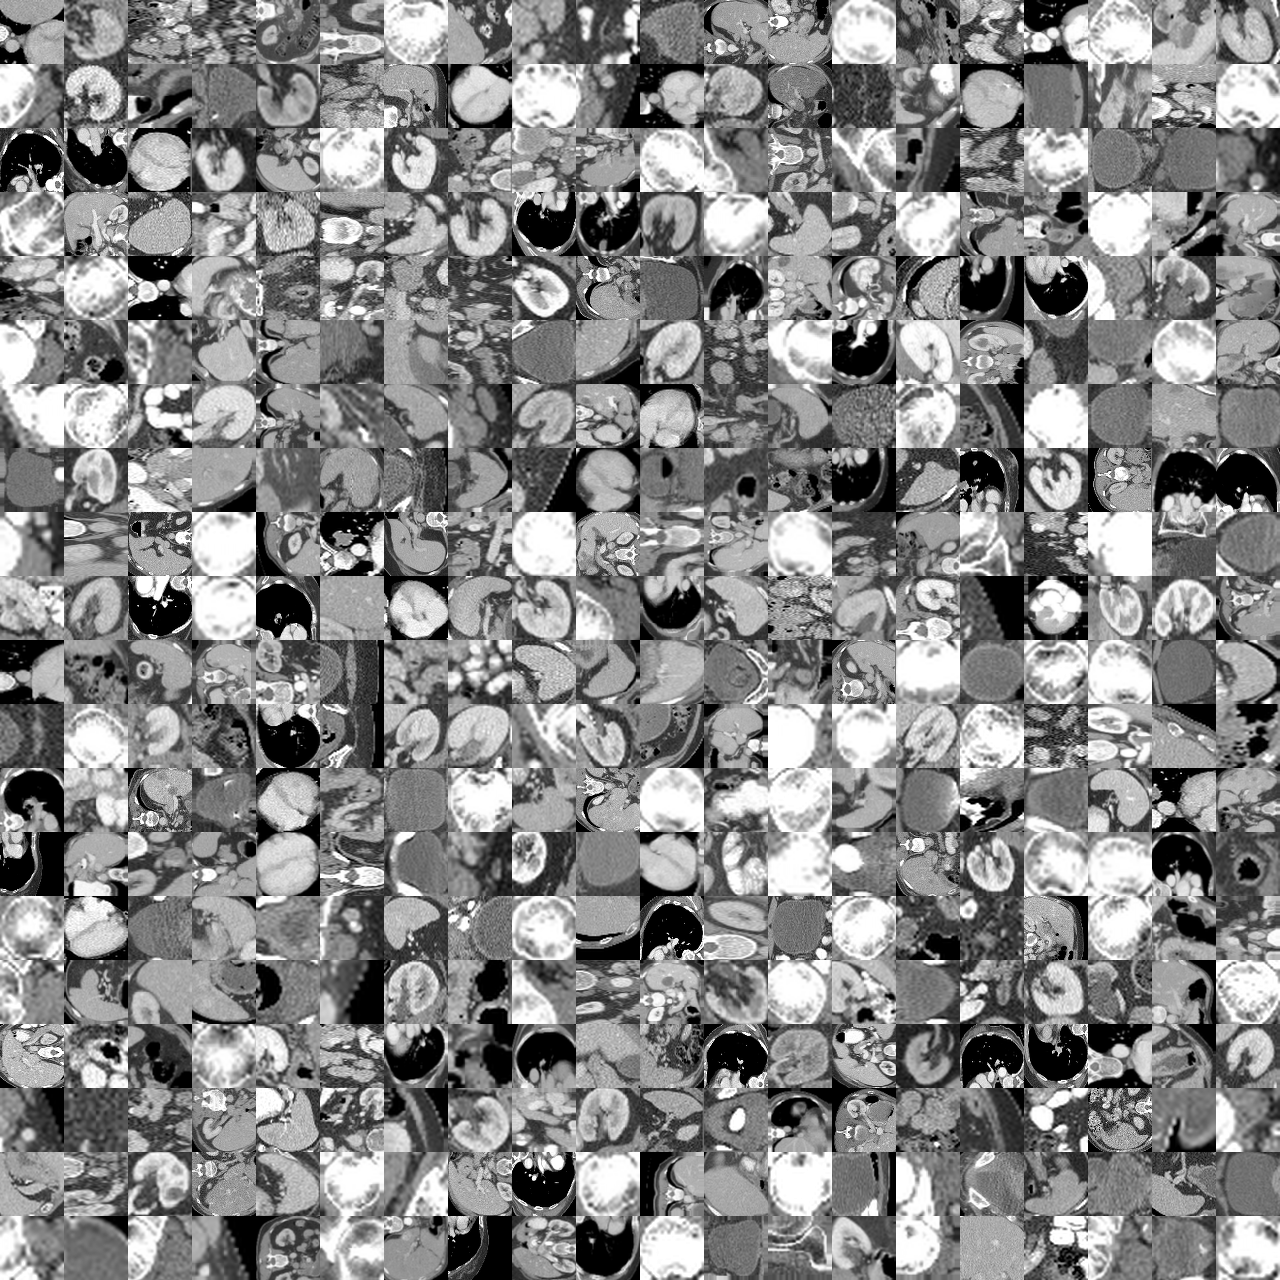

In [14]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

## Pretrained

In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [210]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [211]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 3.0009
2/30, train_loss: 2.6739
3/30, train_loss: 2.8646
4/30, train_loss: 2.5585
5/30, train_loss: 2.5910
6/30, train_loss: 2.4870
7/30, train_loss: 2.2319
8/30, train_loss: 2.2605
9/30, train_loss: 2.4251
10/30, train_loss: 2.5857
11/30, train_loss: 2.3149
12/30, train_loss: 2.5800
13/30, train_loss: 2.2863
14/30, train_loss: 2.3473
15/30, train_loss: 2.0520
16/30, train_loss: 2.1867
17/30, train_loss: 1.8502
18/30, train_loss: 2.2916
19/30, train_loss: 2.1084
20/30, train_loss: 2.1715
21/30, train_loss: 1.8273
22/30, train_loss: 2.1254
23/30, train_loss: 1.8768
24/30, train_loss: 1.9311
25/30, train_loss: 1.6379
26/30, train_loss: 1.6226
27/30, train_loss: 1.8568
28/30, train_loss: 2.0202
29/30, train_loss: 1.7137
30/30, train_loss: 1.8706
31/30, train_loss: 1.4514
epoch 1 average loss: 2.1872
1
saved new best metric model
current epoch: 1 current AUC: 0.6178 current accuracy: 0.1863 best AUC: 0.6178 at epoch: 1
----------
epoch 2/100
1/30, t

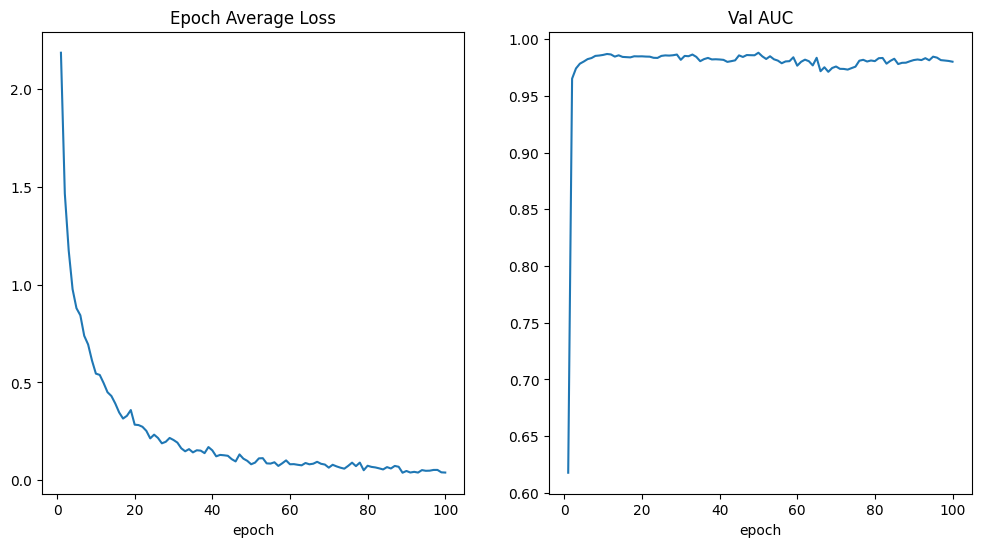

In [212]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [213]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [214]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9275    0.9275    0.9275        69
           1     0.5692    0.5441    0.5564        68
           2     0.5667    0.4928    0.5271        69
           3     0.4079    0.4769    0.4397        65
           4     0.3704    0.3077    0.3361        65
           5     0.8056    0.8788    0.8406        66
           6     0.8667    0.9286    0.8966        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.7727    0.7391    0.7556        69
          10     0.6842    0.7536    0.7172        69

    accuracy                         0.6803       610
   macro avg     0.7246    0.7317    0.7270       610
weighted avg     0.6760    0.6803    0.6768       610



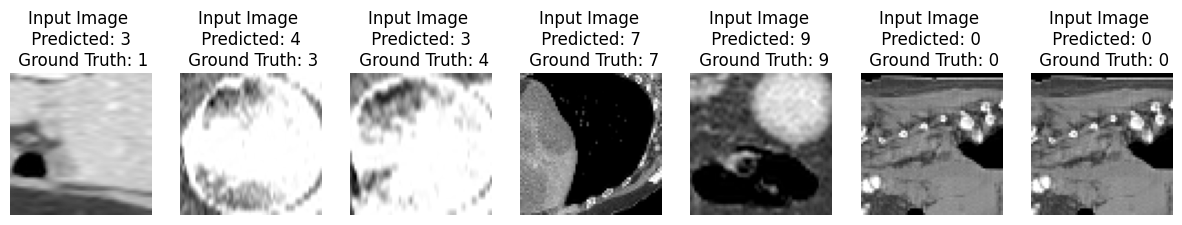

In [215]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [216]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [217]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4904
2/30, train_loss: 2.3619
3/30, train_loss: 2.3993
4/30, train_loss: 2.2934
5/30, train_loss: 2.3759
6/30, train_loss: 2.2202
7/30, train_loss: 2.3531
8/30, train_loss: 2.0522
9/30, train_loss: 2.1722
10/30, train_loss: 2.1168
11/30, train_loss: 2.2089
12/30, train_loss: 1.9520
13/30, train_loss: 2.1465
14/30, train_loss: 2.1106
15/30, train_loss: 1.9556
16/30, train_loss: 1.9904
17/30, train_loss: 1.9043
18/30, train_loss: 1.9893
19/30, train_loss: 1.9131
20/30, train_loss: 1.8272
21/30, train_loss: 1.5654
22/30, train_loss: 2.0591
23/30, train_loss: 1.8517
24/30, train_loss: 1.9336
25/30, train_loss: 1.8377
26/30, train_loss: 1.7052
27/30, train_loss: 1.8816
28/30, train_loss: 1.6729
29/30, train_loss: 2.1059
30/30, train_loss: 1.8400
31/30, train_loss: 1.6898
epoch 1 average loss: 2.0315
1
saved new best metric model
current epoch: 1 current AUC: 0.5781 current accuracy: 0.0932 best AUC: 0.5781 at epoch: 1
----------
epoch 2/100
1/30, t

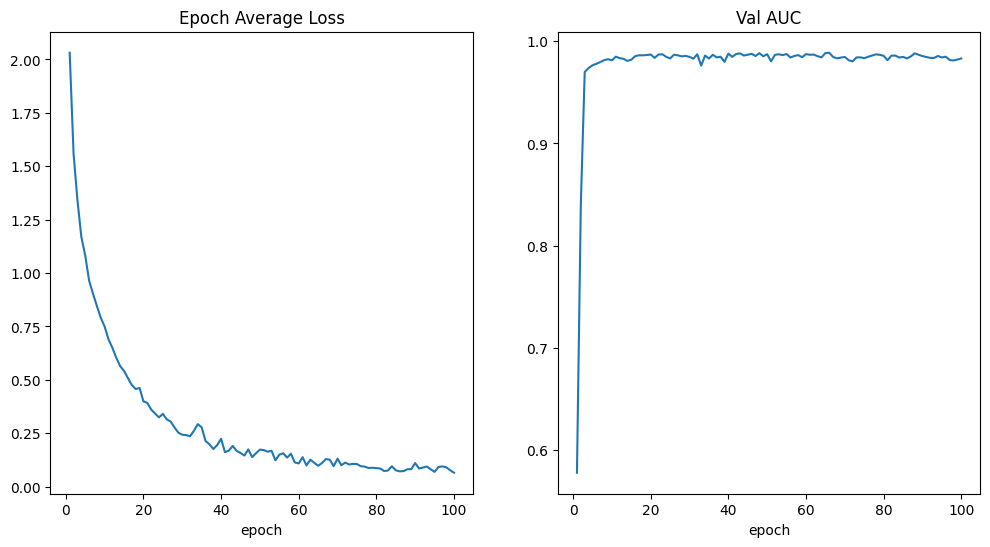

In [218]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [219]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [220]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8023    1.0000    0.8903        69
           1     0.6129    0.5588    0.5846        68
           2     0.6600    0.4783    0.5546        69
           3     0.5254    0.4769    0.5000        65
           4     0.5735    0.6000    0.5865        65
           5     0.8226    0.7727    0.7969        66
           6     0.6970    0.8214    0.7541        28
           7     1.0000    0.7143    0.8333        21
           8     0.7500    1.0000    0.8571        21
           9     0.7241    0.6087    0.6614        69
          10     0.5955    0.7681    0.6709        69

    accuracy                         0.6803       610
   macro avg     0.7058    0.7090    0.6991       610
weighted avg     0.6813    0.6803    0.6741       610



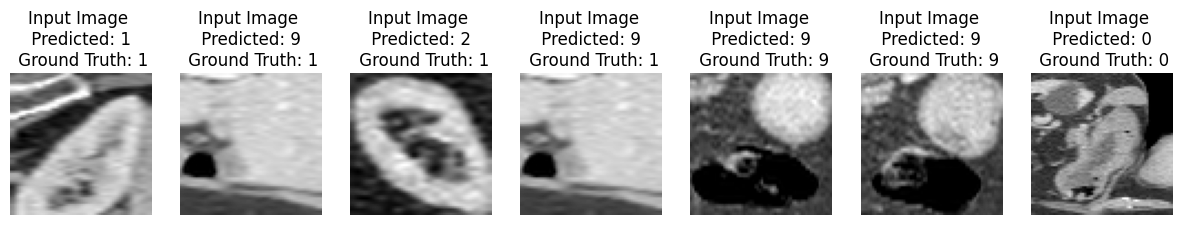

In [221]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [222]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [223]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.5892
2/30, train_loss: 2.7171
3/30, train_loss: 2.8816
4/30, train_loss: 2.9452
5/30, train_loss: 2.6865
6/30, train_loss: 2.4538
7/30, train_loss: 2.5694
8/30, train_loss: 2.4591
9/30, train_loss: 2.5996
10/30, train_loss: 2.2811
11/30, train_loss: 2.0431
12/30, train_loss: 2.2028
13/30, train_loss: 2.2864
14/30, train_loss: 2.3482
15/30, train_loss: 2.2597
16/30, train_loss: 2.1644
17/30, train_loss: 2.0758
18/30, train_loss: 2.1942
19/30, train_loss: 2.0788
20/30, train_loss: 1.7989
21/30, train_loss: 1.8715
22/30, train_loss: 1.7552
23/30, train_loss: 1.8738
24/30, train_loss: 2.0693
25/30, train_loss: 1.9475
26/30, train_loss: 1.8599
27/30, train_loss: 1.6793
28/30, train_loss: 1.7377
29/30, train_loss: 1.6395
30/30, train_loss: 1.8793
31/30, train_loss: 2.0393
epoch 1 average loss: 2.1931
1
saved new best metric model
current epoch: 1 current AUC: 0.7235 current accuracy: 0.2298 best AUC: 0.7235 at epoch: 1
----------
epoch 2/100
1/30, t

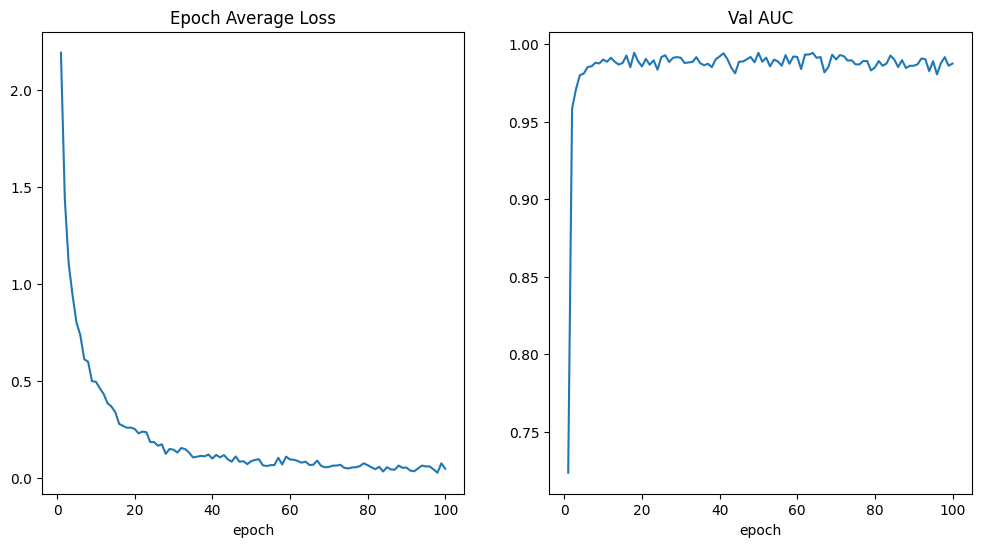

In [224]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [225]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [226]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9028    0.9420    0.9220        69
           1     0.6071    0.5000    0.5484        68
           2     0.6143    0.6232    0.6187        69
           3     0.5672    0.5846    0.5758        65
           4     0.4839    0.4615    0.4724        65
           5     0.7568    0.8485    0.8000        66
           6     0.9200    0.8214    0.8679        28
           7     0.8947    0.8095    0.8500        21
           8     0.8261    0.9048    0.8636        21
           9     0.7667    0.6667    0.7132        69
          10     0.7805    0.9275    0.8477        69

    accuracy                         0.7131       610
   macro avg     0.7382    0.7354    0.7345       610
weighted avg     0.7096    0.7131    0.7090       610



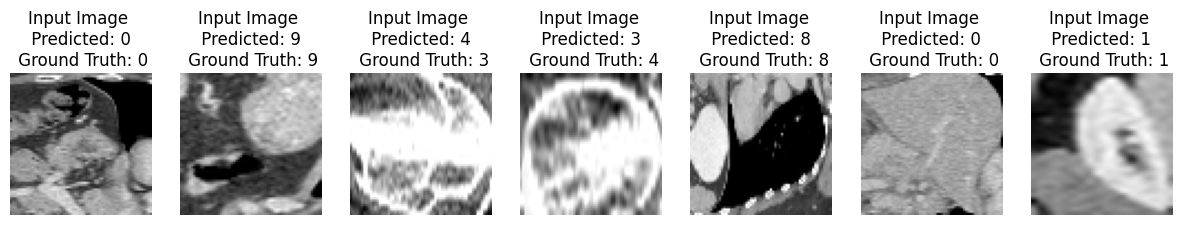

In [227]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_coronal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [230]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.5198
2/30, train_loss: 2.4516
3/30, train_loss: 2.3690
4/30, train_loss: 2.3269
5/30, train_loss: 2.2625
6/30, train_loss: 2.3453
7/30, train_loss: 2.2153
8/30, train_loss: 2.1521
9/30, train_loss: 2.2256
10/30, train_loss: 2.1952
11/30, train_loss: 2.1062
12/30, train_loss: 1.9832
13/30, train_loss: 1.9962
14/30, train_loss: 1.8872
15/30, train_loss: 2.0483
16/30, train_loss: 1.9294
17/30, train_loss: 1.9355
18/30, train_loss: 1.8980
19/30, train_loss: 2.0318
20/30, train_loss: 2.0249
21/30, train_loss: 1.8776
22/30, train_loss: 1.6217
23/30, train_loss: 1.7018
24/30, train_loss: 1.8850
25/30, train_loss: 1.8427
26/30, train_loss: 1.9436
27/30, train_loss: 1.7268
28/30, train_loss: 1.9523
29/30, train_loss: 1.7323
30/30, train_loss: 1.7573
31/30, train_loss: 1.9899
epoch 1 average loss: 2.0302
1
saved new best metric model
current epoch: 1 current AUC: 0.6099 current accuracy: 0.0932 best AUC: 0.6099 at epoch: 1
----------
epoch 2/100
1/30, t

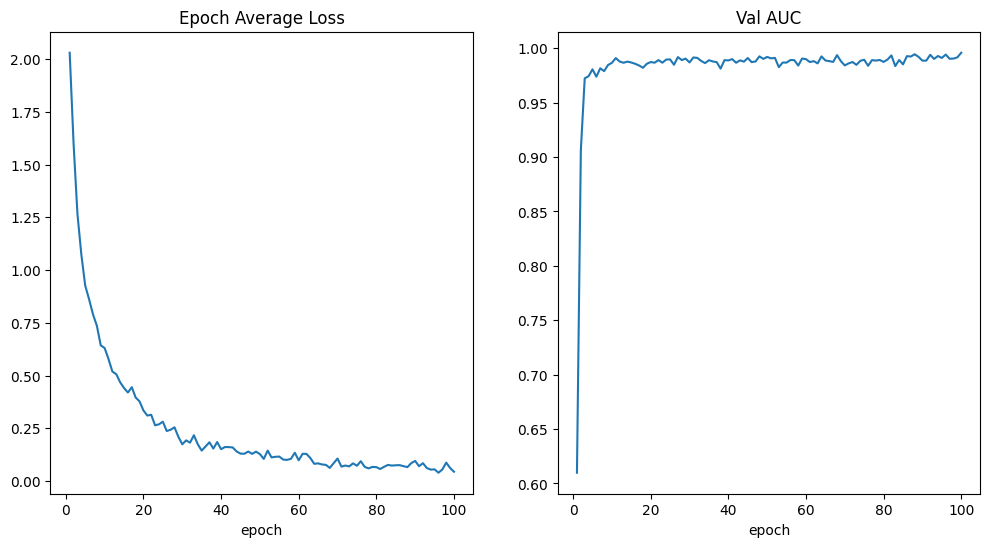

In [231]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [232]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [233]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.7349    0.8841    0.8026        69
           1     0.4857    0.5000    0.4928        68
           2     0.6275    0.4638    0.5333        69
           3     0.4545    0.5385    0.4930        65
           4     0.4915    0.4462    0.4677        65
           5     0.7121    0.7121    0.7121        66
           6     0.7778    0.5000    0.6087        28
           7     0.8077    1.0000    0.8936        21
           8     1.0000    0.4762    0.6452        21
           9     0.6562    0.6087    0.6316        69
          10     0.3953    0.4928    0.4387        69

    accuracy                         0.5885       610
   macro avg     0.6494    0.6020    0.6108       610
weighted avg     0.6030    0.5885    0.5874       610



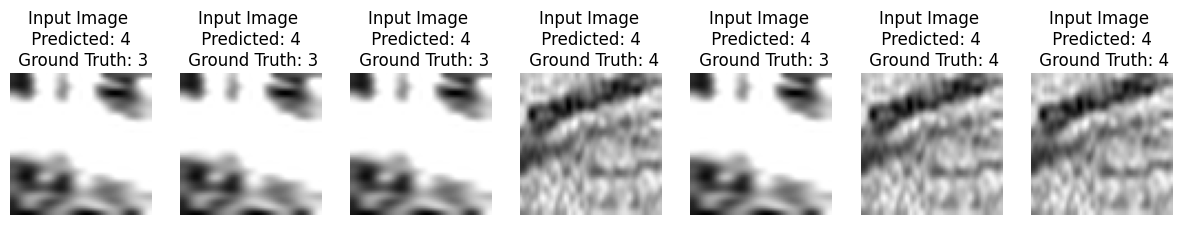

In [234]:
plot_examples(test_coronal, pred, test_labels, n=7)

## Training cycle for the sagittal part

## Pretrained

In [235]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [236]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.8663
2/30, train_loss: 2.7746
3/30, train_loss: 2.7643
4/30, train_loss: 2.4267
5/30, train_loss: 2.4749
6/30, train_loss: 2.6350
7/30, train_loss: 2.8416
8/30, train_loss: 2.8406
9/30, train_loss: 2.3613
10/30, train_loss: 2.6910
11/30, train_loss: 2.1610
12/30, train_loss: 2.4669
13/30, train_loss: 2.4406
14/30, train_loss: 2.5263
15/30, train_loss: 2.1833
16/30, train_loss: 1.9971
17/30, train_loss: 2.0224
18/30, train_loss: 2.1998
19/30, train_loss: 2.1926
20/30, train_loss: 2.0274
21/30, train_loss: 2.5243
22/30, train_loss: 1.8799
23/30, train_loss: 2.0331
24/30, train_loss: 2.1392
25/30, train_loss: 2.0086
26/30, train_loss: 1.8973
27/30, train_loss: 1.9628
28/30, train_loss: 1.9692
29/30, train_loss: 2.1203
30/30, train_loss: 1.7724
31/30, train_loss: 1.9486
epoch 1 average loss: 2.2951
1
saved new best metric model
current epoch: 1 current AUC: 0.5524 current accuracy: 0.0870 best AUC: 0.5524 at epoch: 1
----------
epoch 2/100
1/30, t

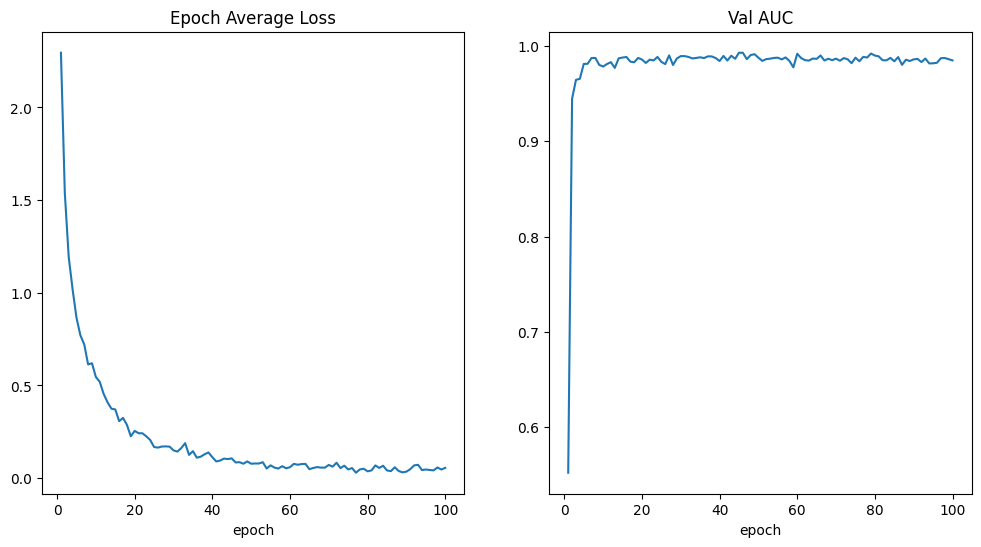

In [237]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [238]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [239]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9000    0.9130    0.9065        69
           1     0.5250    0.6176    0.5676        68
           2     0.3590    0.2029    0.2593        69
           3     0.6143    0.6615    0.6370        65
           4     0.6364    0.5385    0.5833        65
           5     0.7662    0.8939    0.8252        66
           6     1.0000    0.8929    0.9434        28
           7     0.9412    0.7619    0.8421        21
           8     0.8000    0.9524    0.8696        21
           9     0.6627    0.7971    0.7237        69
          10     0.8551    0.8551    0.8551        69

    accuracy                         0.7066       610
   macro avg     0.7327    0.7352    0.7284       610
weighted avg     0.6946    0.7066    0.6953       610



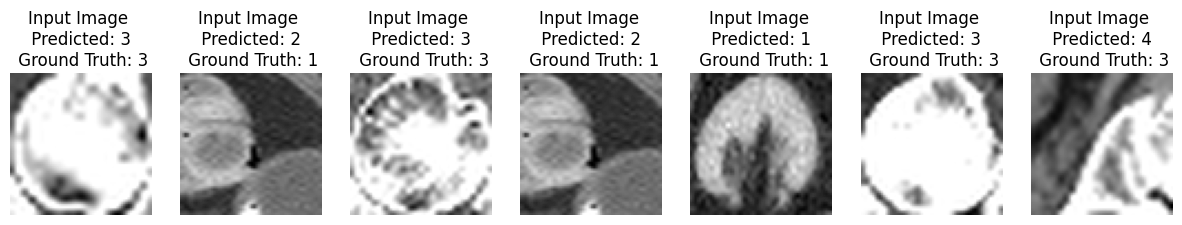

In [240]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_sagittal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [241]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [242]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.5851
2/30, train_loss: 2.5164
3/30, train_loss: 2.3948
4/30, train_loss: 2.4348
5/30, train_loss: 2.5344
6/30, train_loss: 2.3983
7/30, train_loss: 2.2154
8/30, train_loss: 2.2736
9/30, train_loss: 2.1933
10/30, train_loss: 2.0538
11/30, train_loss: 2.0544
12/30, train_loss: 2.0044
13/30, train_loss: 2.1993
14/30, train_loss: 1.9013
15/30, train_loss: 2.0451
16/30, train_loss: 1.9268
17/30, train_loss: 1.8873
18/30, train_loss: 1.8657
19/30, train_loss: 2.1208
20/30, train_loss: 1.9102
21/30, train_loss: 1.8873
22/30, train_loss: 1.9308
23/30, train_loss: 1.9788
24/30, train_loss: 1.9220
25/30, train_loss: 1.6704
26/30, train_loss: 1.8151
27/30, train_loss: 1.9905
28/30, train_loss: 1.8090
29/30, train_loss: 2.2877
30/30, train_loss: 2.1615
31/30, train_loss: 2.3951
epoch 1 average loss: 2.1085
1
saved new best metric model
current epoch: 1 current AUC: 0.6077 current accuracy: 0.0932 best AUC: 0.6077 at epoch: 1
----------
epoch 2/100
1/30, t

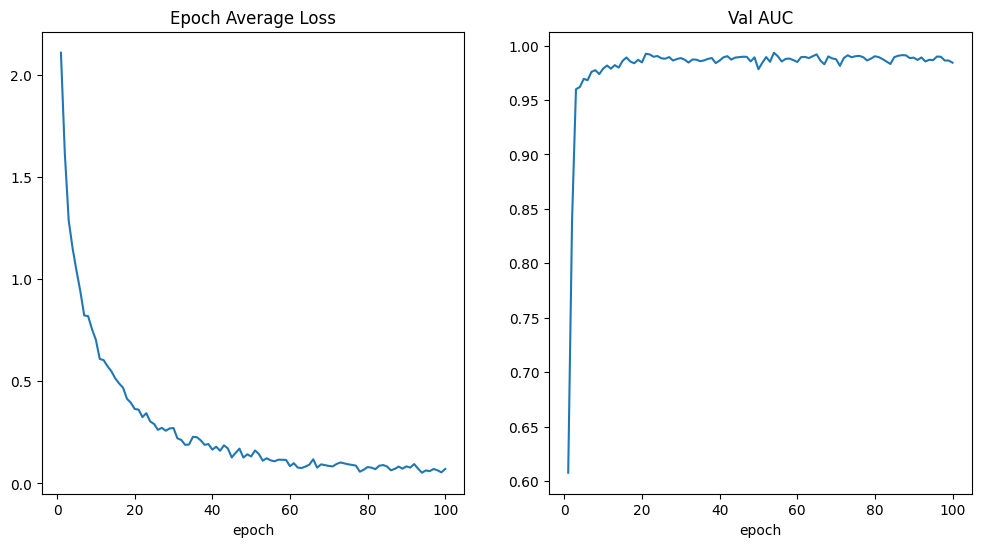

In [243]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [244]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [245]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.6216    0.3333    0.4340        69
           1     0.3293    0.3971    0.3600        68
           2     0.3000    0.1304    0.1818        69
           3     0.4545    0.3077    0.3670        65
           4     0.4423    0.3538    0.3932        65
           5     0.5079    0.4848    0.4961        66
           6     0.3846    0.3571    0.3704        28
           7     0.4444    0.3810    0.4103        21
           8     0.2000    0.1905    0.1951        21
           9     0.2673    0.3913    0.3176        69
          10     0.2482    0.4928    0.3301        69

    accuracy                         0.3557       610
   macro avg     0.3818    0.3473    0.3505       610
weighted avg     0.3896    0.3557    0.3556       610



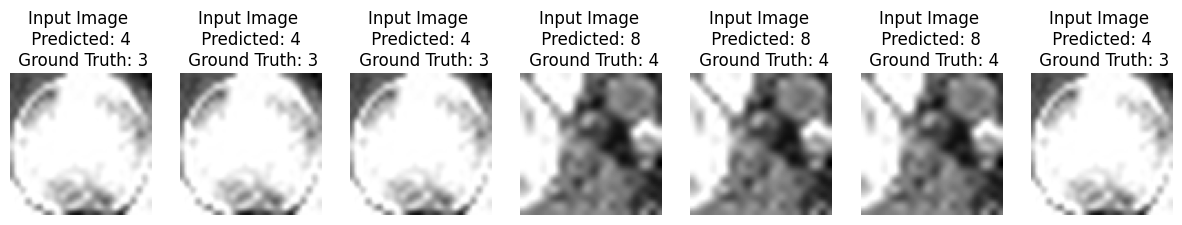

In [246]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## 3D slices evaluation

In [247]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data):
        dims = data.shape
        axial, coronal, sagittal = [], [], []
        middle_idx = [dims[i] // 2 for i in range(0, 4)]
        
        for d in range(3):  # 0 - Axial, 1 - Coronal, 2 - Sagittal
            start_idx = middle_idx[d] - 4  # Start 4 slices before the middle
            end_idx = middle_idx[d] + 5    # End 4 slices after the middle
            
            for i in range(start_idx, end_idx):
                if d == 0:
                    axial.append(data[:, i, :, :])
                elif d == 1:
                    coronal.append(data[:, :, i, :])
                elif d == 2:
                    sagittal.append(data[:, :, :, i])
        
        return axial, coronal, sagittal

In [248]:
train_dataset_ = Sliced_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = Sliced_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = Sliced_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Pretrained

In [249]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)


model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_axial.eval()

model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_coronal.eval()

model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model_sagittal.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        for i in range(9):
            pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
            pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
            pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
            if i != 0:
                pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
            else:
                pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [250]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9388    0.6667    0.7797        69
           1     0.4912    0.4118    0.4480        68
           2     0.4419    0.2754    0.3393        69
           3     0.5897    0.3538    0.4423        65
           4     0.5439    0.4769    0.5082        65
           5     0.5439    0.9394    0.6889        66
           6     1.0000    0.6071    0.7556        28
           7     0.8462    0.5238    0.6471        21
           8     0.9048    0.9048    0.9048        21
           9     0.5138    0.8116    0.6292        69
          10     0.7033    0.9275    0.8000        69

    accuracy                         0.6164       610
   macro avg     0.6834    0.6272    0.6312       610
weighted avg     0.6344    0.6164    0.6021       610



## Unpretrained

In [251]:
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_axial.eval()
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_coronal.eval()
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model_sagittal.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        for i in range(9):
            pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
            pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
            pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
            if i != 0:
                pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
            else:
                pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

In [252]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8415    1.0000    0.9139        69
           1     0.5541    0.6029    0.5775        68
           2     0.7250    0.4203    0.5321        69
           3     0.5506    0.7538    0.6364        65
           4     0.6667    0.4615    0.5455        65
           5     0.8939    0.8939    0.8939        66
           6     0.9600    0.8571    0.9057        28
           7     0.8750    1.0000    0.9333        21
           8     1.0000    0.9048    0.9500        21
           9     0.7838    0.8406    0.8112        69
          10     0.8750    0.9130    0.8936        69

    accuracy                         0.7574       610
   macro avg     0.7932    0.7862    0.7812       610
weighted avg     0.7616    0.7574    0.7498       610



# Using 2d models as a backbone

In [282]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [283]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [284]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [285]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [286]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.8894766992138279
Epoch 2, Loss: 1.127507294377973
Epoch 3, Loss: 0.6983896743866705
Epoch 4, Loss: 0.47233119414698693
Epoch 5, Loss: 0.32541028482298695
Epoch 6, Loss: 0.26442477683867177
Epoch 7, Loss: 0.2087584844520015
Epoch 8, Loss: 0.18112605185278
Epoch 9, Loss: 0.16708870256139385
Epoch 10, Loss: 0.13405601439937467
Epoch 11, Loss: 0.1165160553589944
Epoch 12, Loss: 0.10567549159449915
Epoch 13, Loss: 0.09751079207466494
Epoch 14, Loss: 0.08733611469787936
Epoch 15, Loss: 0.0914224601320682
Epoch 16, Loss: 0.07502635976960582
Epoch 17, Loss: 0.07016574074664424
Epoch 18, Loss: 0.0651247051935042
Epoch 19, Loss: 0.06702897944036991
Epoch 20, Loss: 0.06368882449403886
Epoch 21, Loss: 0.058564071753813375
Epoch 22, Loss: 0.05665339980154268
Epoch 23, Loss: 0.04878688874023576
Epoch 24, Loss: 0.044082914388948874
Epoch 25, Loss: 0.04353893482156338
Epoch 26, Loss: 0.044459124366121906
Epoch 27, Loss: 0.043553795725587874
Epoch 28, Loss: 0.0442346945525177
Epoch 29,

In [287]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9975, Accuracy: 14.7391


In [288]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [289]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9710    0.9710    0.9710        69
           1     0.6515    0.6324    0.6418        68
           2     0.6935    0.6232    0.6565        69
           3     0.5541    0.6308    0.5899        65
           4     0.6000    0.6000    0.6000        65
           5     0.9524    0.9091    0.9302        66
           6     1.0000    0.9643    0.9818        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8636    0.8261    0.8444        69
          10     0.8816    0.9710    0.9241        69

    accuracy                         0.7967       610
   macro avg     0.8334    0.8298    0.8309       610
weighted avg     0.7991    0.7967    0.7971       610



## Pretrained

In [290]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [291]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [292]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [293]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.3610180577924176
Epoch 2, Loss: 1.727011546011894
Epoch 3, Loss: 1.2905763752998844
Epoch 4, Loss: 1.0010385071077654
Epoch 5, Loss: 0.7863319073953936
Epoch 6, Loss: 0.6403116660733377
Epoch 7, Loss: 0.5664645020038851
Epoch 8, Loss: 0.49281080115226006
Epoch 9, Loss: 0.41321150285582386
Epoch 10, Loss: 0.3852202512564198
Epoch 11, Loss: 0.3372620300900552
Epoch 12, Loss: 0.30083633959293365
Epoch 13, Loss: 0.2844950455811716
Epoch 14, Loss: 0.26074735243474284
Epoch 15, Loss: 0.2616283042776969
Epoch 16, Loss: 0.23246142941136513
Epoch 17, Loss: 0.20355899776181868
Epoch 18, Loss: 0.21788255870342255
Epoch 19, Loss: 0.18200464955260676
Epoch 20, Loss: 0.1918885313695477
Epoch 21, Loss: 0.16656227217566583
Epoch 22, Loss: 0.18181114331368478
Epoch 23, Loss: 0.15158692026330578
Epoch 24, Loss: 0.14066639614682044
Epoch 25, Loss: 0.15727875670117716
Epoch 26, Loss: 0.13727931678295135
Epoch 27, Loss: 0.13419496580477683
Epoch 28, Loss: 0.13128934392044622
Epoch 29, Loss

In [294]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9960, Accuracy: 14.7205


In [295]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [296]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8933    0.9710    0.9306        69
           1     0.5938    0.5588    0.5758        68
           2     0.5000    0.5072    0.5036        69
           3     0.6410    0.7692    0.6993        65
           4     0.7091    0.6000    0.6500        65
           5     0.9524    0.9091    0.9302        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8413    0.7681    0.8030        69
          10     0.8442    0.9420    0.8904        69

    accuracy                         0.7738       610
   macro avg     0.8159    0.8043    0.8077       610
weighted avg     0.7761    0.7738    0.7726       610



## Hyper network

In [297]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [298]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [299]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [300]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.116183130971847
Epoch 2, Loss: 1.6396860653354275
Epoch 3, Loss: 1.2701680775611632
Epoch 4, Loss: 0.9934753583323571
Epoch 5, Loss: 0.7850971337287657
Epoch 6, Loss: 0.6184626471611762
Epoch 7, Loss: 0.5071875433767995
Epoch 8, Loss: 0.42673027611547903
Epoch 9, Loss: 0.371258677974824
Epoch 10, Loss: 0.3190277353409798
Epoch 11, Loss: 0.28465611127115065
Epoch 12, Loss: 0.25124959887996795
Epoch 13, Loss: 0.22511673069769336
Epoch 14, Loss: 0.20307729225004872
Epoch 15, Loss: 0.1844824278546918
Epoch 16, Loss: 0.17658133348149638
Epoch 17, Loss: 0.16191228118634993
Epoch 18, Loss: 0.15469292142698843
Epoch 19, Loss: 0.1388192289779263
Epoch 20, Loss: 0.12714394494410483
Epoch 21, Loss: 0.12313884328449926
Epoch 22, Loss: 0.11573370714341441
Epoch 23, Loss: 0.11039685722320311
Epoch 24, Loss: 0.11062713784556236
Epoch 25, Loss: 0.09853445029547138
Epoch 26, Loss: 0.09328976381690271
Epoch 27, Loss: 0.09056162245331272
Epoch 28, Loss: 0.08569677390398518
Epoch 29, Loss

In [301]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9970, Accuracy: 14.7578


In [302]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [303]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9855    0.9714        69
           1     0.6567    0.6471    0.6519        68
           2     0.7069    0.5942    0.6457        69
           3     0.5676    0.6462    0.6043        65
           4     0.6000    0.6000    0.6000        65
           5     0.9531    0.9242    0.9385        66
           6     1.0000    0.9286    0.9630        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.8769    0.8261    0.8507        69
          10     0.8590    0.9710    0.9116        69

    accuracy                         0.7967       610
   macro avg     0.8302    0.8250    0.8263       610
weighted avg     0.7986    0.7967    0.7962       610



## Pretrained

In [304]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [305]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [306]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.305636682818013
Epoch 2, Loss: 1.9362605579437748
Epoch 3, Loss: 1.656137551030805
Epoch 4, Loss: 1.4013941749449699
Epoch 5, Loss: 1.2238573951105918
Epoch 6, Loss: 1.0628042221069336
Epoch 7, Loss: 0.9326447075413119
Epoch 8, Loss: 0.8415898584550426
Epoch 9, Loss: 0.7327701564758055
Epoch 10, Loss: 0.6651678969783168
Epoch 11, Loss: 0.6214999066245172
Epoch 12, Loss: 0.5602016737384181
Epoch 13, Loss: 0.5180797336562988
Epoch 14, Loss: 0.4860600444578355
Epoch 15, Loss: 0.44460294611992374
Epoch 16, Loss: 0.4156335101973626
Epoch 17, Loss: 0.3862928344357398
Epoch 18, Loss: 0.36778935597788903
Epoch 19, Loss: 0.35220134979294193
Epoch 20, Loss: 0.3259613086139002
Epoch 21, Loss: 0.3289909939612112
Epoch 22, Loss: 0.2914905495220615
Epoch 23, Loss: 0.27303867138201193
Epoch 24, Loss: 0.2700944533271174
Epoch 25, Loss: 0.27119281407325496
Epoch 26, Loss: 0.2525447412363945
Epoch 27, Loss: 0.2558254541889314
Epoch 28, Loss: 0.2465095438303486
Epoch 29, Loss: 0.22239256

In [307]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9978, Accuracy: 14.8012


In [308]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [309]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9286    0.9420    0.9353        69
           1     0.6154    0.7059    0.6575        68
           2     0.5500    0.4783    0.5116        69
           3     0.6714    0.7231    0.6963        65
           4     0.7031    0.6923    0.6977        65
           5     0.9677    0.9091    0.9375        66
           6     1.0000    0.8571    0.9231        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.8209    0.7971    0.8088        69
          10     0.9041    0.9565    0.9296        69

    accuracy                         0.7934       610
   macro avg     0.8287    0.8194    0.8227       610
weighted avg     0.7953    0.7934    0.7932       610

